### Import modules

In [6]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Read the [dataset](https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset)

In [7]:
data=pd.read_csv("completeSpamAssassin.csv")
data.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


### Data Preprocessing

In [8]:
data.drop("Unnamed: 0",inplace=True,axis=1)
data.dropna(inplace=True)
no_link=[re.sub(r"http\S+",'',i) for i in data['Body']]
clean=[re.sub(r"[^a-z0-9A-Z]",' ',i) for i in no_link] 
lower=[i.lower() for i in clean]
tokens=[nltk.word_tokenize(i) for i in lower]
lemma=WordNetLemmatizer()
lemmatized=[[lemma.lemmatize(w) for w in token] for token in tokens]     #make the words in the same form
stopwords = nltk.corpus.stopwords.words("english")
no_stopwords=[[w for w in text if w not in stopwords] for text in lemmatized] 

### Using  <font color='CornflowerBlue'>Naive Bayes</font> to do the classification 

In [9]:
vectorizer = CountVectorizer(max_features=2000)
X = vectorizer.fit_transform([' '.join(text) for text in no_stopwords]).toarray()
y=data['Label']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.3)
nb_model=GaussianNB()
nb_model.fit(X_train,y_train)
y_pred=nb_model.predict(X_test)
target_name=["Ham","Spam"]
print("Naive Bayes's accuracy: ", metrics.accuracy_score(y_test,y_pred) )
print(classification_report(y_test,y_pred,target_names=target_name))


Naive Bayes's accuracy:  0.8009922822491731
              precision    recall  f1-score   support

         Ham       0.97      0.74      0.84      1251
        Spam       0.62      0.94      0.75       563

    accuracy                           0.80      1814
   macro avg       0.79      0.84      0.79      1814
weighted avg       0.86      0.80      0.81      1814



### Plot the ROC curve based on y_test

0.841409998111635


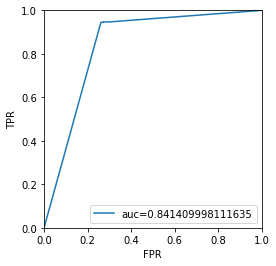

In [10]:
y_pred_proba=nb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds= metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
label="auc="+str(auc)
plt.plot(fpr, tpr)
plt.legend([label],loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("Naive_Bayes_Graph/roc_curve.png")
print(auc)

### Plot the confusion matrix, analyzing the performance of the model

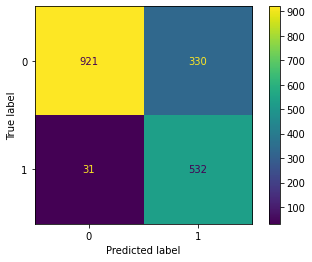

In [11]:
#confusion matrix
Confusion=metrics.confusion_matrix(y_test,y_pred)
Confusion_display=metrics.ConfusionMatrixDisplay(confusion_matrix=Confusion)
Confusion_display.plot()
plt.savefig("Naive_Bayes_Graph/confusion_matrix.png")
plt.show()

### Get the index of the emails which are classified as spam 

In [12]:
idx=0
no_str=no_stopwords.copy()
no_str=np.array(no_str,dtype=object)
spam_index=[]
spam_string=[]
for idx,i in enumerate(y_pred) :
    if i==1:        #1 for spam
        spam_index.append(idx)
for text in no_str[spam_index]:
    tmp=' '.join(text)
    spam_string.append(tmp)

### Count the frequency of words in the spam email

In [13]:
vectorizer=CountVectorizer(max_features=2000)
X_Spam=vectorizer.fit_transform(spam_string).toarray()
x_df=pd.DataFrame(X_Spam,columns=vectorizer.get_feature_names_out())
x_df.head(1)

,00,000,000000,001,01,02,03,06,07,096400,...,xxx,yahoo,year,yellow,yes,yet,york,yr,zimbabwe,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Test which column start to begin with "English word"

In [14]:
x_df.iloc[:,128:].head(1)

,ability,able,absolute,absolutely,abuse,ac,accept,accepted,accepting,access,...,xxx,yahoo,year,yellow,yes,yet,york,yr,zimbabwe,zip
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
x_df.drop(x_df.iloc[:, 0:128], axis = 1,inplace=True)

### Plot the bar chart, get to know the words which are in the top 50 that contribute more to the spam email

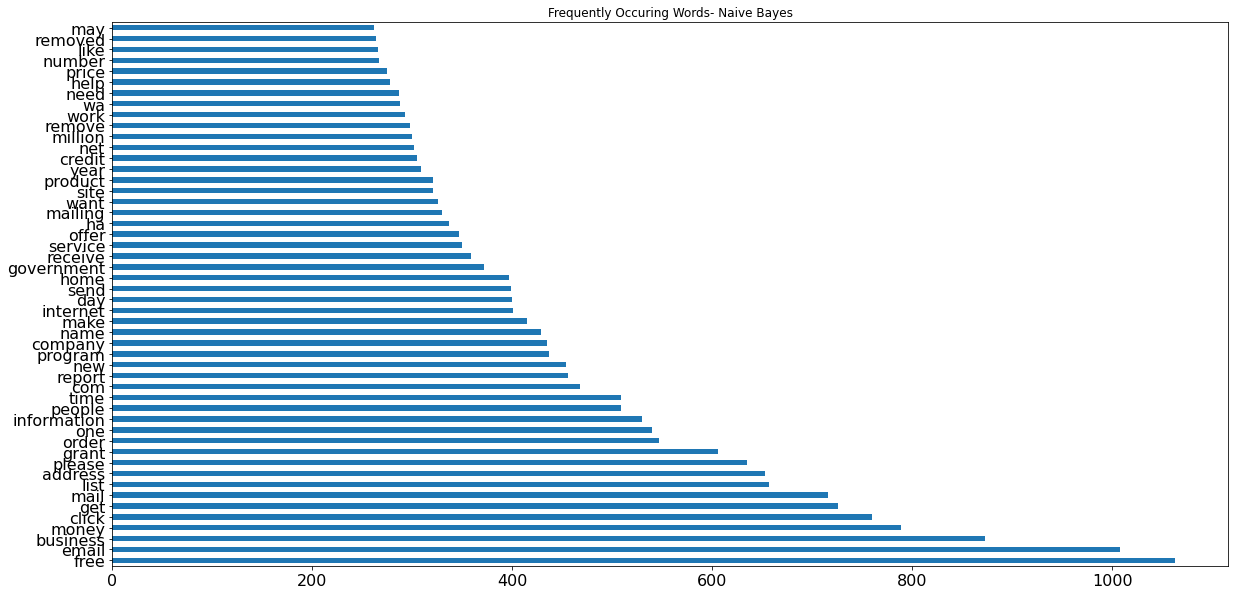

In [25]:
PLOTdf=x_df.sum().sort_values(ascending=False).head(50).plot(kind='barh',
                                                                  figsize=(20,10),
                                                                  fontsize=16,
                                                                  title='Frequently Occuring Words- Naive Bayes')
fig = PLOTdf.get_figure()
fig.savefig("Naive_Bayes_Graph/contribute.png")

### Using <font color='CornflowerBlue'>elbow method </font> to find the optimal k for k-means

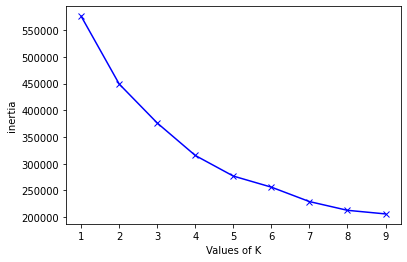

In [17]:
Interia=[]
for k in range(1,10):
    kmeans=KMeans(n_clusters=k,random_state=42)
    kmeans.fit(X_Spam)
    Interia.append(kmeans.inertia_)
plt.plot(range(1,10),Interia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('inertia')
plt.savefig('Naive_Bayes_Graph/elbow-method.png')
plt.show()

### Using <font color='CornflowerBlue'>k-means </font> to cluster the words

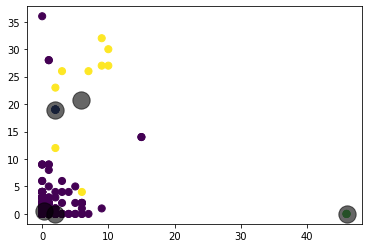

In [18]:
## Using Kmeans to cluster the words
kmeans=KMeans(n_clusters=5,max_iter=600)

fitted = kmeans.fit(X_Spam)
prediction = kmeans.predict(X_Spam)
# 
plt.scatter(X_Spam[:, 0], X_Spam[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6)
plt.savefig('Naive_Bayes_Graph/kmeans.png')
plt.show()

### Using tf-idf vectorizer to compute the importance of the words in the dataset

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
tf_idf_vectorizor = TfidfVectorizer(stop_words = nltk.corpus.stopwords.words("english"),max_features = 2000)
tf_idf = tf_idf_vectorizor.fit_transform(data['Body'])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 20)

### Visulaize top 15 representative words in one cluster

##### Graph of cluster 1

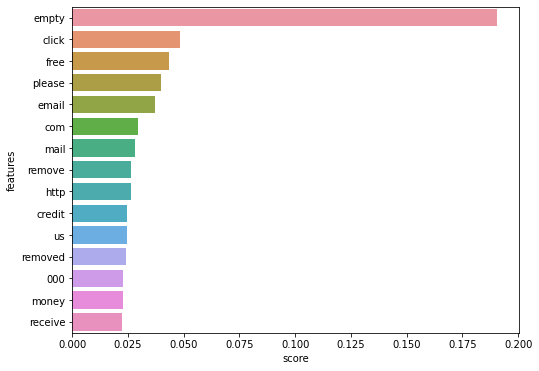

In [20]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])
plt.savefig("Naive_Bayes_Graph/cluster1")

##### Graph of cluster 2

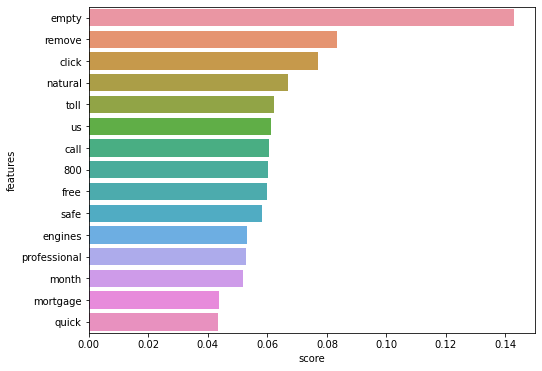

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])
plt.savefig("Naive_Bayes_Graph/cluster2")

##### Graph of cluster 3

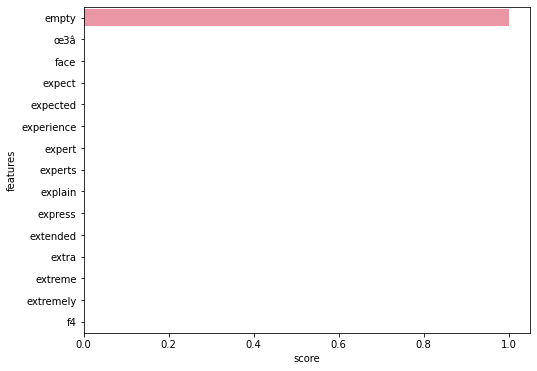

In [22]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])
plt.savefig("Naive_Bayes_Graph/cluster3")

##### Graph of cluster 4

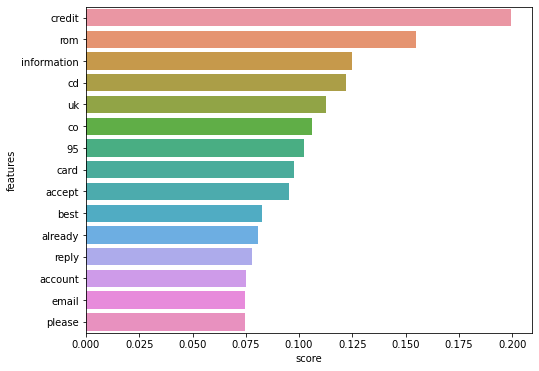

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:15])
plt.savefig("Naive_Bayes_Graph/cluster4")

##### Graph of cluster 5

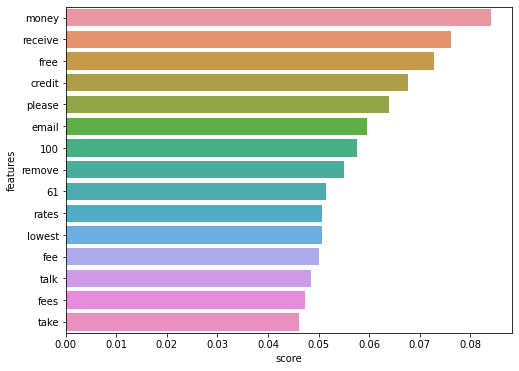

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[4][:15])
plt.savefig("Naive_Bayes_Graph/cluster5")